# imports

In [1]:
import pygeostat as gs
import numpy as np
np.set_printoptions(precision=4, suppress=True)
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os, copy, shutil, sys, glob, time
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.backends.backend_pdf import PdfPages
from collections import OrderedDict
import numba
from scipy import stats
%matplotlib inline
mpl.style.use("seaborn-ticks")
gs.set_style("ccgpaper", custom={"figure.dpi":150, "savefig.dpi": 150})

# import the working module and functions

In [4]:
from functions import *
import agglomclus as agg

# datafile

In [6]:
data = gs.read_gslib("synthetic.dat")
variables = ['Var1','Var2']

# standardize

In [7]:
stdvar, means, variances = standardize(data, variables=variables)
for var in stdvar.columns:
    data[var] = stdvar[var]
data['std_x'] = (data['x'] - np.mean(data['x'])) / np.std(data['x'])
data['std_y'] = (data['y'] - np.mean(data['y'])) / np.std(data['y'])
stdvariables = list(stdvar.columns)

In [8]:
tdata, _ = gs.nscore(data, variables)    
for var in tdata.columns:
    data[var] = tdata[var]
nsvariables = tdata.columns.tolist()

In [9]:
variables, stdvariables, nsvariables

(['Var1', 'Var2'], ['std_Var1', 'std_Var2'], ['NS_Var1', 'NS_Var2'])

# locmaps

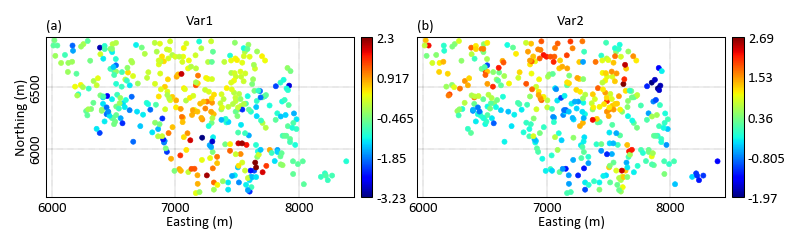

In [11]:
pltstyle='pt7'
pointsize = 6
def iterplts(axes, caxes):
    iax = 0
    for var, ax, cax in zip(variables, axes, caxes):
        cmap = 'jet'
        gs.locmap(data, x="x", y="y", 
                  var=var, cmap=cmap, ax=ax, cax=cax, pltstyle=pltstyle,
                  unit='m', grid=True, rotateticks=(False, True), s=pointsize, title=var)
        fixlabels(ax)
        label_subplot(ax, iax, fontsize=7)
        iax += 1
        yield ax    
fig = gs.imagegrid(nrow=1, ncol=2, gridfunc=iterplts, cbar='each', labelmode="L",
                   ntickbins=3, axes_pad=(0.3, 0.18), rotateticks=(False, True), pltstyle=pltstyle)
gs.exportimg('Figures/synthetic_locmap_vars.png')

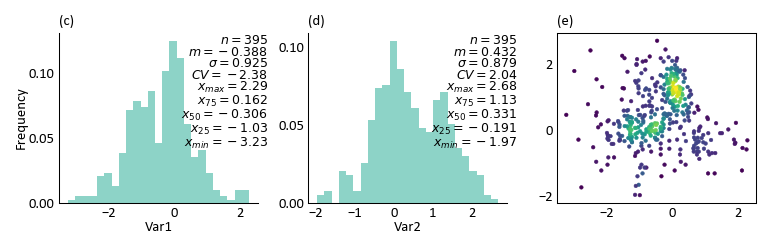

In [48]:
pltstyle = 'pt7'
def iterplts(axes):
    iax = 2
    for ax, var in zip(axes[:-1], variables):
        gs.histplt(data[var], stat_blk='all', ax=ax, pltstyle=pltstyle, xlabel=var,
                   stat_fontsize=6, stat_linespc=0.9, stat_xy=(1.05, 0.99))
        fixlabels(ax)
        label_subplot(ax, iax, fontsize=7)
        iax += 1
        yield ax
    ax = axes[2]
    d = simple_density_calc(data['Var1'], data['Var2'], 8)
    pts = ax.scatter(data['Var1'], data['Var2'], c=d, s=3, lw=0.25, cmap='viridis')
    fixlabels(ax)
    label_subplot(ax, iax, fontsize=7)
    yield ax
fig = gs.imagegrid(nrow=1, ncol=3, gridfunc=iterplts, pltstyle=pltstyle, unequal_aspects=True, 
                   figsize=(6, 1.5), ntickbins=(6, 3), axes_pad=(0.25))
fig.axes[1].set_ylabel('')
gs.exportimg('Figures/synth_dscplt.png')

# MV only hierarchical clustering

In [13]:
data['hier'] = cluster(3, data[variables], n_init=1, algorithm='hier') + 1

# typical hierarchical clustering with the coordinates as variables

In [15]:
hiervars = copy.copy(variables)
hiervars.insert(0, 'std_y')
hiervars.insert(0, 'std_x')
hierdat, _ = gs.nscore(data, hiervars)
data['hier_coords'] = cluster(3, hierdat, n_init=1, algorithm='hier') + 1
data['hier_coords'], _ = reclass_cluster_single(data['hier'], 
                                                         data['hier_coords'])

# autocorr spatial clustering

In [17]:
autocorr = AutocorrClus(data[variables], data[['x', 'y']], nnears=10, 
                           clustermethod='hier', autocor='morans')
data['autocorr'] = autocorr.fit_predict(3) + 1
data['autocorr'], _ = reclass_cluster_single(data['hier'], data['autocorr'])

# agglom spatial clustering

In [18]:
agglm = agg.AgglomCluster(data[variables], data[['x', 'y']], nnears=10, stage1merge=4, 
                         niter=100, seed=77747)
agglm.fit(7, minprop=0.0001, verbose=True, ipdiff=1)

A Jupyter Widget

In [19]:
data['agglm'] = agglm.predict(3)
data['agglm'], _= reclass_cluster_single(data['autocorr'], data['agglm'])

# plotting

In [20]:
mdsp1 = MDSPlot(data[variables], mtype='mds', randstate=78129)
mdsp1.embed()
mdsp1.coords = data[variables].values

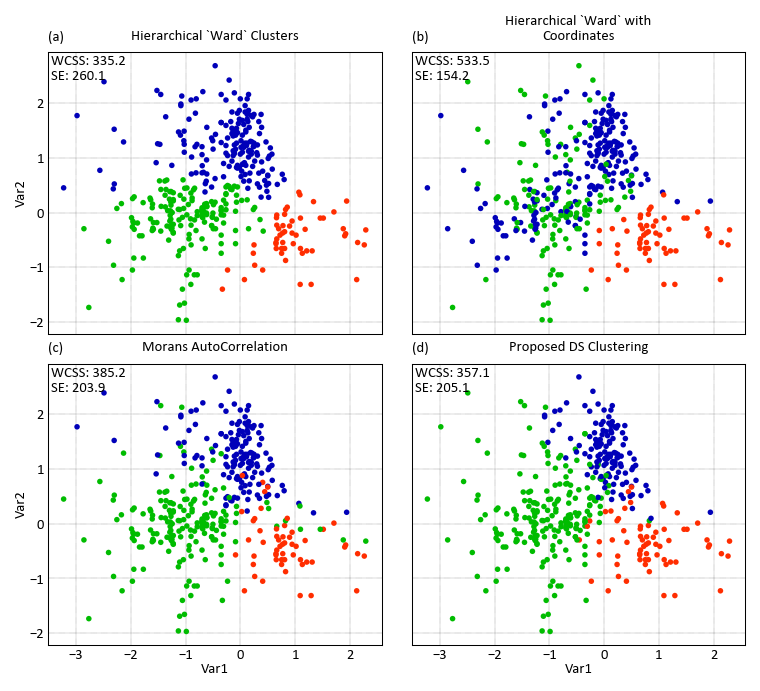

In [23]:
cols = ['hier', 'hier_coords', 'autocorr', 'agglm']
titles = ['Hierarchical `Ward` Clusters', 'Hierarchical `Ward` with\nCoordinates', 
          'Morans AutoCorrelation', 'Proposed DS Clustering']
def iterplts(axes):
    iax=0
    for ax, col, title in zip(axes, cols, titles):
        ax = mdsp1.plot_mds(colors=data[col], cmap='spectral', pltstyle='pt7', ax=ax, 
                            title=title, legend_loc=False, s=7, lw=0.01, xlabel='Var1', 
                            ylabel='Var2')
        label_subplot(ax, fignum=iax, fontsize=7)
        agg.label_cluster_stats(data[nsvariables], data[['x', 'y']], 
                               data[col], 25, (0, 0, 0, 1, 1), ax)
        iax += 1
        yield ax
fig = gs.imagegrid(ncol=2, nrow=2, gridfunc=iterplts, labelmode='L', ntickbins=10, pltstyle='pt7')
gs.exportimg('Figures/synth_cluster_mdsplots.png')

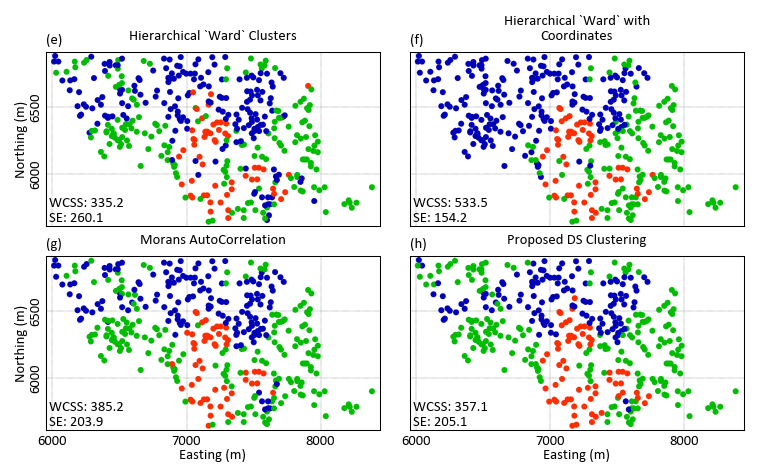

In [24]:
def iterplts(axes):
    iax = 4
    for ax, col, title in zip(axes, cols, titles):
        ax = gs.locmap(data, x="x", y="y", var=col, cmap='spectral', pltstyle='pt7', ax=ax, title=title, grid=True, 
                       rotateticks=(False, True), s=8, lw=0.05, unit='m')
        label_subplot(ax, fignum=iax, fontsize=7)
        fixlabels(ax)
        agg.label_cluster_stats(data[nsvariables], data[['x', 'y']], 
                                data[col], 25, (0, 0, 0, 1, 1), ax, top=False)
        iax += 1
        yield ax
fig = gs.imagegrid(ncol=2, nrow=2, gridfunc=iterplts, labelmode='L', ntickbins=3, pltstyle='pt7', 
                   rotateticks=(False, True))
gs.exportimg('Figures/synth_cluster_locmaps.png')

# feature importance for the different methods

In [25]:
from sklearn.ensemble import ExtraTreesClassifier

In [26]:
data.columns

Index(['x', 'y', 'Var1', 'Var2', 'std_Var1', 'std_Var2', 'std_x', 'std_y',
       'NS_Var1', 'NS_Var2', 'hier', 'hier_coords', 'autocorr', 'agglm'],
      dtype='object')

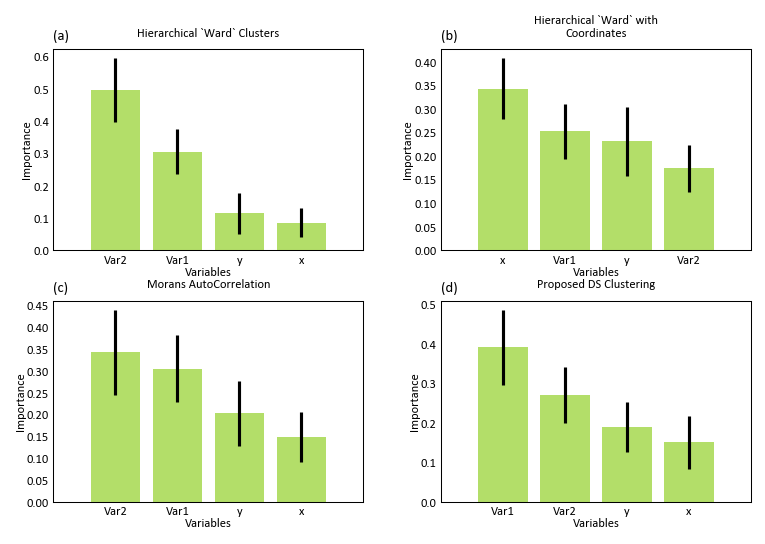

In [27]:
treevars = copy.copy(variables)
treevars.insert(0, 'x')
treevars.insert(1, 'y')
gs.set_style('pt6')
impvars = []
def iterplts(axes):
    iax = 0
    for ax, col, title in zip(axes, cols, titles):
        forest = ExtraTreesClassifier(n_estimators=250, random_state=0, criterion='gini', 
                                      )
        X = data[treevars]
        y = data[col]
        forest.fit(X, y)
        importances = forest.feature_importances_
        std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                      axis=0)
        indices = np.argsort(importances)[::-1]

        # Plot the feature importances of the forest
        ax.set_title(title)
        ax.bar(range(X.shape[1]), importances[indices], color=gs.cat_palettes['cat_pastel'][6], 
               yerr=std[indices], align="center")
        impvars = [treevars[idx] for idx in indices]
        ax.xaxis.set_ticks(range(X.shape[1]))
        ax.xaxis.set_ticklabels(impvars)
        ax.set_xlim([-1, X.shape[1]])
        ax.set_ylabel('Importance')
        ax.set_xlabel('Variables')
        fixlabels(ax)
        label_subplot(ax, fignum=iax, fontsize=7)
        iax += 1
        yield ax
fig = gs.imagegrid(ncol=2, nrow=2, gridfunc=iterplts, pltstyle='pt6', unequal_aspects=True, 
                   figsize=(6, 4), ntickbins=10, axes_pad=(0.25, 0.25))
gs.exportimg('Figures/synth_cluster_importance.png')

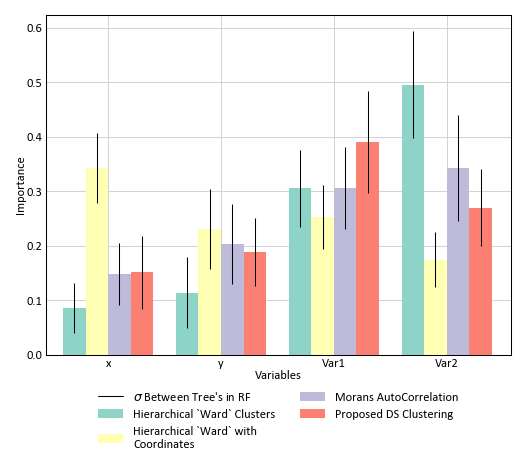

In [28]:
treevars = copy.copy(variables)
treevars.insert(0, 'x')
treevars.insert(1, 'y')
gs.set_style('pt6')
impvars = []
colors = gs.cat_palettes['cat_pastel']
f, ax = plt.subplots(1, 1, figsize=(4, 3))
iax = 0
for ioff, (col, title) in enumerate(zip(cols, titles)):
    forest = ExtraTreesClassifier(n_estimators=250, random_state=0, criterion='gini')
    X = data[treevars]
    y = data[col]
    forest.fit(X, y)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                  axis=0)
    ax.bar(np.arange(X.shape[1]) + (ioff-0.5) * 0.2, importances, width=0.2,
           color=colors[ioff], yerr=std, align="center", error_kw={"lw":0.5}, 
           label=title)
ax.plot(np.nan, lw=0.5, color='k', label="$\sigma$ Between Tree's in RF")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07), ncol=2)
ax.xaxis.set_ticks(np.arange(X.shape[1]) + 0.2)
ax.xaxis.set_ticklabels(treevars)
ax.set_xlim([-0.35, 0.9425 * X.shape[1]])
ax.set_ylabel('Importance')
ax.set_xlabel('Variables')
fixlabels(ax)
ax.grid(True)
gs.exportimg('Figures/synth_cluster_importance.png')

# sensitivity

In [29]:
def clusteringplot(x, wcss, se, xlabel, title=None, y1=None, y2=None):
    f, ax = plt.subplots(figsize=(3, 2.5))
    ax.plot(x, wcss, color=gs.cat_palettes["cat_pastel"][2],
            label="WCSS")
    ax2 = ax.twinx()
    ax2.plot(x, se, color=gs.cat_palettes["cat_pastel"][5])
    ax.plot(np.nan, color=gs.cat_palettes["cat_pastel"][5], label="Spatial\nEntropy")
    for a in [ax, ax2]:
        fixlabels(a)
    ax.set_xbound(x.min(), x.max())
    ax.set_ylabel("WCSS")
    ax2.set_ylabel("Spatial Entropy")
    ax.set_xlabel(xlabel)
    ax.grid(True)
    ax.legend(loc="center right")
    if title is not None: 
        ax.set_title(title)
    if y1 is not None:
        ax.set_ylim(y1)
    if y2 is not None:
        ax2.set_ylim(y2)
    return ax 

# nnears == numtake

In [30]:
sens_clusts = {}
iterable = np.arange(2, 15, 3, dtype=int)
for nnears in gs.log_progress(iterable):
    numtake = nnears
    agglm = agg.AgglomCluster(data[variables], data[['x', 'y']], 
                             nnears=nnears, stage1merge=numtake, niter=100, seed=77747)
    agglm.fit(8, minprop=0.0001, maxprop=0.9999, verbose=False, ipdiff=0)

    key = 'agg_%s_%s' % (nnears, numtake)
    sens_clusts[key] = agglm.predict(3)
    sens_clusts[key], _ = reclass_cluster_single(data['agglm'], 
                                                    sens_clusts[key])

A Jupyter Widget

In [31]:
res = []
tdata = copy.deepcopy(data)
mvdata = tdata[nsvariables].values
locations = tdata[['x', 'y']].values
for nnears in iterable:
    numtake = nnears
    key = 'agg_%s_%s' % (nnears, numtake)
    wcss, spentropy = agg.calc_cluster_stats(mvdata, locations, sens_clusts[key], 25)
    res.append([nnears, numtake, wcss, spentropy])
res = np.array(res)

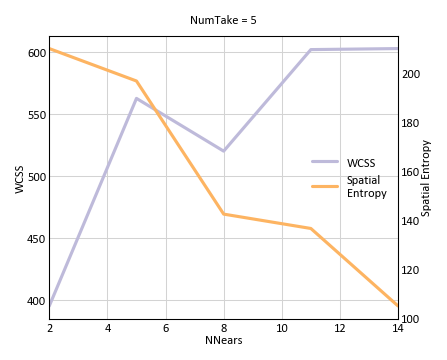

In [32]:
clusteringplot(x=res[:, 0], wcss=res[:, 2], se=res[:, 3], xlabel="NNears", title="NumTake = 5")

# nnears = 25, numtake variable

In [33]:
clusts = {}
nnears = 25
iterable = np.arange(1, nnears)
for numtake in gs.log_progress(iterable):
    agglm = agg.AgglomCluster(data[variables], data[['x', 'y']], 
                             nnears=nnears, stage1merge=numtake, niter=100, 
                              seed=77747)
    agglm.fit(8, minprop=0.0001, maxprop=0.9999, verbose=False, ipdiff=0)

    key = 'agg_%s_%s' % (nnears, numtake)
    clusts[key] = agglm.predict(3)
    clusts[key], _ = reclass_cluster_single(data['agglm'], 
                                                    clusts[key])

A Jupyter Widget

In [34]:
res2 = []
tdata = copy.deepcopy(data)
mvdata = tdata[nsvariables].values
locations = tdata[['x', 'y']].values
for numtake in iterable:
    key = 'agg_%s_%s' % (nnears, numtake)
    wcss, spentropy = agg.calc_cluster_stats(mvdata, locations, clusts[key], 25)
    res2.append([nnears, numtake, wcss, spentropy])
res2 = np.array(res2)

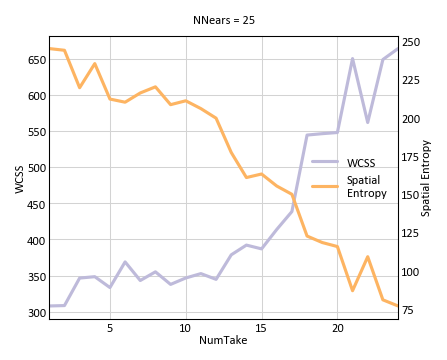

In [35]:
clusteringplot(res2[:, 1], res2[:, 2], res2[:, 3], "NumTake", title="NNears = 25")

# numtake = 5, nnears = variable

In [36]:
clusts = {}
numtake = 5
iterable = np.arange(2, 55, 2)
for nnears in gs.log_progress(iterable):
    agglm = agg.AgglomCluster(data[variables], data[['x', 'y']], 
                             nnears=nnears, stage1merge=numtake, niter=100, seed=77747)
    agglm.fit(8, minprop=0.0001, maxprop=0.9999, verbose=False, ipdiff=0)

    key = 'agg_%s_%s' % (nnears, numtake)
    clusts[key]= agglm.predict(3)
    clusts[key], _ = reclass_cluster_single(data['agglm'], 
                                                    clusts[key])

A Jupyter Widget

In [37]:
res3 = []
tdata = copy.deepcopy(data)
mvdata = tdata[nsvariables].values
locations = tdata[['x', 'y']].values
for nnears in iterable:
    key = 'agg_%s_%s' % (nnears, numtake)
    wcss, spentropy = agg.calc_cluster_stats(mvdata, locations, clusts[key], 25)
    res3.append([nnears, numtake, wcss, spentropy])
res3 = np.array(res3)

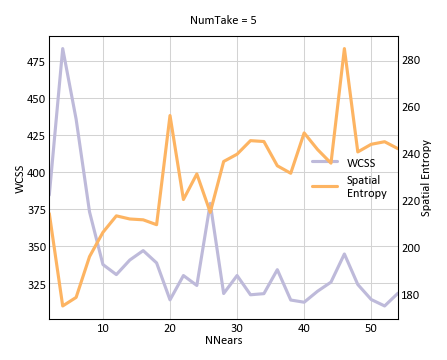

In [38]:
clusteringplot(res3[:, 0], res3[:, 2], res3[:, 3], "NNears", title="NumTake = 5")

# $K_{miniclusters}$

A Jupyter Widget

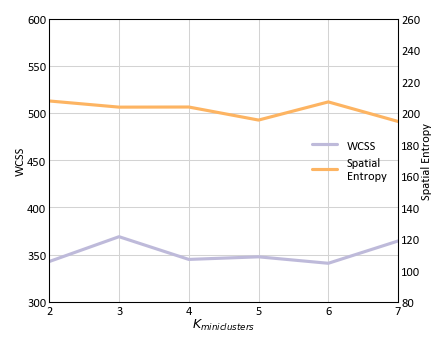

In [39]:
# $K_{miniclusters}$

clusts = {}
numtake = 5
nnears = 10
iterable = range(2, 8)
for kmini in gs.log_progress(iterable):
    agglm = agg.AgglomCluster(data[variables], data[['x', 'y']], 
                             nnears=nnears, stage1merge=numtake, niter=100, seed=77747)
    agglm.fit(kmini, minprop=0.0001, maxprop=0.9999, verbose=False, ipdiff=0)

    key = kmini
    clusts[key]= agglm.predict(3)
    clusts[key], _ = reclass_cluster_single(data['agglm'], 
                                                    clusts[key])

res4 = []
tdata = copy.deepcopy(data)
mvdata = tdata[nsvariables].values
locations = tdata[['x', 'y']].values
for kmini in iterable:
    key = kmini
    wcss, spentropy = agg.calc_cluster_stats(mvdata, locations, clusts[key], 25)
    res4.append([kmini, numtake, wcss, spentropy])
res4 = np.array(res4)

clusteringplot(res4[:, 0], res4[:, 2], res4[:, 3], "$K_{miniclusters}$", 
               y1=(300, 600), y2=(80, 260))

# random seed

In [40]:
clusts = {}
numtake = 10
nnears = 10
kmini = 6
nnears2 = 5
iterable = np.arange(35)
for iseed in gs.log_progress(iterable):
    agglm = agg.AgglomCluster(data[variables], data[['x', 'y']], 
                              nnears=nnears, stage1merge=numtake, 
                              niter=100, seed=int(gs.rseed()))
    agglm.fit(kmini, minprop=0.0001, maxprop=0.9999, verbose=False, ipdiff=0)
    key = iseed
    clusts[key]= agglm.predict(3)
    clusts[key], _ = reclass_cluster_single(data['agglm'], 
                                                    clusts[key])

res6 = []
tdata = copy.deepcopy(data)
mvdata = tdata[nsvariables].values
locations = tdata[['x', 'y']].values
for iseed in iterable:
    key = iseed
    wcss, spentropy = agg.calc_cluster_stats(mvdata, locations, clusts[key], 25)
    res6.append([iseed, numtake, wcss, spentropy])
res6 = np.array(res6)

A Jupyter Widget

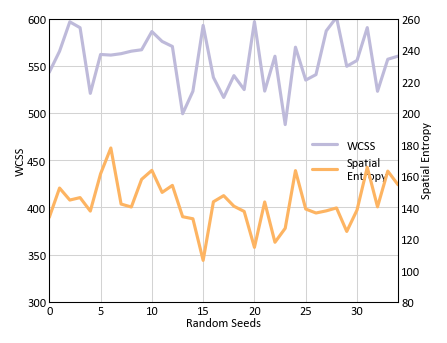

In [41]:
clusteringplot(res6[:, 0], res6[:, 2], res6[:, 3], "Random Seeds", 
               y1=(300, 600), y2=(80, 260))